<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Brief-background" data-toc-modified-id="Brief-background-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Brief background</a></span></li><li><span><a href="#Fetch-data" data-toc-modified-id="Fetch-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fetch data</a></span></li><li><span><a href="#Structure-learning" data-toc-modified-id="Structure-learning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Structure learning</a></span><ul class="toc-item"><li><span><a href="#Discretization" data-toc-modified-id="Discretization-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Discretization</a></span></li></ul></li></ul></div>

# Brief background

To establish causal relationships between development indicators and mixed-migration, we now model the state of the system as a graphical model. A graphical model is a representation of (conditional) dependence of a set of random variables. 

The framework represents the system as a graph, with **nodes** representing state variables (indicators such as GDP, mixed migration, conflict, etc.) and **edges** representing dependency. Given evidence, such a network can be learnt from the data directly (although this is computationally intensive to explore the possible graph structures as the number of state variables increase). This task is one of *structure learning*. 

If a partial set of dependencies are available from experts, based on domain specific insights or field experience, then the structure can be "bootstrapped" with this dependence structure. Such a structure is shown below:

![Domain expert causal structure](img/PartialBN.jpg)

In [2]:
import os
import json
import pandas as pd
import numpy as np
from time import time

from  pomegranate  import BayesianNetwork
import pygraphviz
import networkx
import tempfile

import seaborn as sns
import matplotlib.image as mpl_image
import matplotlib.pyplot as plt

%matplotlib inline 
sns.set(style="white")

# Fetch data

Review the [README.md](README.md) file on how to download and set up a copy of the pre-processed data. We'll use the [configuration.json](configuration.json) file to gather all the sources.

We focus on 6 bilateral flows for this phase all originating in Ethiopia. The destination countries are: Saudi Arabia, Italy, Great Britain, Denmark, Sweden, and South Africa. These variables are included in the pre-processed dataset and are encoded as `ETH.TO.xxx` (where `xxx` refers to the ISO-3 code of the destination country). 

In [ ]:
start_time = time()
with open("configuration.json", 'rt') as infile:
    config = json.load(infile)

sources = [os.path.join(config['paths']['output'], 
                        d['name'], 
                        'data.csv') for d in config['sources']]


# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), sort=False, ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Row count          : {}".format(len(df)))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))

print("\nLoaded data in {:3.2f} sec.".format(time() - start_time))

# Structure learning

What is the relationship between these indicators? We start with a simple model with one country pair and no temporal dependence. One limitation on structure learning is that they work for discrete distributions. So we discretize the state variables first. 

## Discretization


In [ ]:
# Organize the indicators in "long form"
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

In [ ]:
def plot_bins(s, ax, discrete_bins=3, plot_bins=100):
    """ Visualize the raw distribution and bins for indicators """

    
    s.dropna(inplace=True)
    
    # Discretize the series
    _, xbins = pd.cut(s, discrete_bins, retbins=True)
    
    ax.hist(s, bins=plot_bins, density=True)
    ax.set_yticks([], [])
    ax.set_xticks([], [])
    # add reference lines
    [ax.axvline(xb, **{'color': 'red', 'linestyle': 'dotted'}) for xb in xbins]
    
    ax.set_title(s.name + "\n(n={})".format(len(s)))

from random import sample
cols = sample(list(data.columns), k=16)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i, c in enumerate(cols):
    
    plot_bins(data[c], ax=axes[np.unravel_index(i, axes.shape)])
    

In [ ]:
# Discretization scheme

# TODO: This is primitive, consider:
# - (min-max) after looking at the distributions
# - https://arxiv.org/pdf/1512.02406.pdf 

def discretization(x, BINS=3):
    """ Discretize indicators """
    return pd.cut(x, BINS, labels=False)
    

X = data.apply(discretization, axis=1)

X.head()

In [8]:
G = pygraphviz.AGraph(directed=True)
G.add_node("a")
G.add_node("b")
G.add_node("c")
G.add_edge("a", "b")
G.add_edge("b", "a")

for n in G.nodes():
    if G.degree(n) == 0:
        G.delete_node(n)
        
print(G.nodes())

['a', 'b']


In [9]:
# Model plot
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 20)

def plot_model(model):
    """ Helper function - due to outdated Networkx dependency """
    
    G = pygraphviz.AGraph(directed=True)
    
    G.node_attr['fontsize'] = '20'
    #G.node_attr['fontcolor']='#FFFFFF'
    
    for state in model.states:
        
        G.add_node(state.name, color='blue', shape='circle')

    for parent, child in model.edges:
        G.add_edge(parent.name, child.name, color='blue')
        
    # Remove un-connected nodes
    for n in G.nodes():
        if G.degree(n) == 0:
            G.delete_node(n)
    

    """
    with tempfile.NamedTemporaryFile() as tf:
        G.draw(tf.name, format='png', prog='dot')
        img = mpl_image.imread(tf.name)
        plt.imshow(img)
        plt.axis('off')
        # plt.savefig("test.png")
    """
    with open("test.png", 'wb') as tf:
        G.draw(tf, format='png', prog='dot')
    

def plot_networkx(Q, node_label=None, edge_label=None, filename=None):
    """ Pomegranate requires Networkx 1.11 (outdated) and built in plots don't work """
    
    G = pygraphviz.AGraph(directed=True)

    for state in Q.nodes():
        if node_label:
            G.add_node(state,  label=node_label[state])
        else:
            G.add_node(state)

    for parent, child, data in Q.edges(data=True):
        if edge_label:
            G.add_edge(parent, child, label=data[edge_label])
        else:
            G.add_edge(parent, child)


    with tempfile.NamedTemporaryFile() as tf:
        G.draw(tf.name, format='png', prog='dot')
        img = mpl_image.imread(tf.name)
        plt.imshow(img)
        plt.axis('off')
        

In [ ]:
G = networkx.DiGraph()
cols = X.columns.tolist()

nodes = {} # node to ID dictionary


with open("network.json", 'rt') as infile:
    net = json.load(infile)


# Driver clusters (node sets) from expert-network
for clus, indicator in net['nodes'].items():
    
    # build the index sets based on the data
    index = []
    for i in indicator:
        try:
            index.append(cols.index(i))
        except ValueError:
            raise ValueError("{} indicator not in data.".format(i))
    
    nodes[clus] = index

# Map the edges
edge_count = 0
for clus, to_nodes in net['edges'].items():
    
    fidx = nodes[clus]
    
    for tn in to_nodes:
        
        tidx = nodes[tn]
        
        if fidx and tidx:
        
            G.add_edge(tuple(fidx), tuple(tidx))
            edge_count += 1

print("Domain network with {} node clusters and {} edges.".format(len(nodes), edge_count))
nlabels = {tuple(v):k for k, v in nodes.items()}
plot_networkx(G, node_label=nlabels)

In [ ]:
start_time = time()
model = BayesianNetwork.from_samples(X, 
                                     algorithm='exact',
                                     state_names=X.columns,
                                     constraint_graph=G,
                                     n_jobs=-1)
print("Structure learning (constrained) in {:3.2f} sec.".format(time() - start_time))

In [10]:
# Load cached model structure
with open("model.json", 'rt') as infile:
    mj = infile.read()
    
model = BayesianNetwork.from_json(mj)
plot_model(model)

In [56]:
# Get the domain expert network
with open("network.json", 'rt') as infile:
    net = json.load(infile)
    
clus = {i: lbl for lbl, indsets in net['nodes'].items() for i in indsets}
    
G = pygraphviz.AGraph(directed=True, strict=False)
for nodes, _ in net['nodes'].items():
    G.add_node(nodes)

for src, destinations in net['edges'].items():
    for des in destinations:
        G.add_edge(src, des, style='dotted', color='red')
        

# Get the learnt structure 
with open("model.json", 'rt') as infile:
    mj = infile.read()
    
model = BayesianNetwork.from_json(mj)
print("Model with {} edges.".format(model.edge_count()))
data_links = []
for parent, child in model.edges:
    
    try:
        i = clus[parent.name]
        
        
        try:
            j = clus[child.name]
            
            if (i, j) not in data_links:
                data_links.append((i, j))
            
        except KeyError:
            G.add_node(child.name)
            data_links.append((i, child.name))
    
    except KeyError:
        
        try:
            j = clus[child.name]
            
            G.add_node(parent.name)
            data_links.append((parent.name, j))
            
        except KeyError:
            
            continue

for i, j in data_links:
    G.add_edge(i, j, style='solid', penwidth='2', color='blue')
    

"""
with open("img/data-vs-expert2.png", 'wb') as tf:
    G.draw(tf, format='png', prog='dot')
""";

Model with 57 edges.


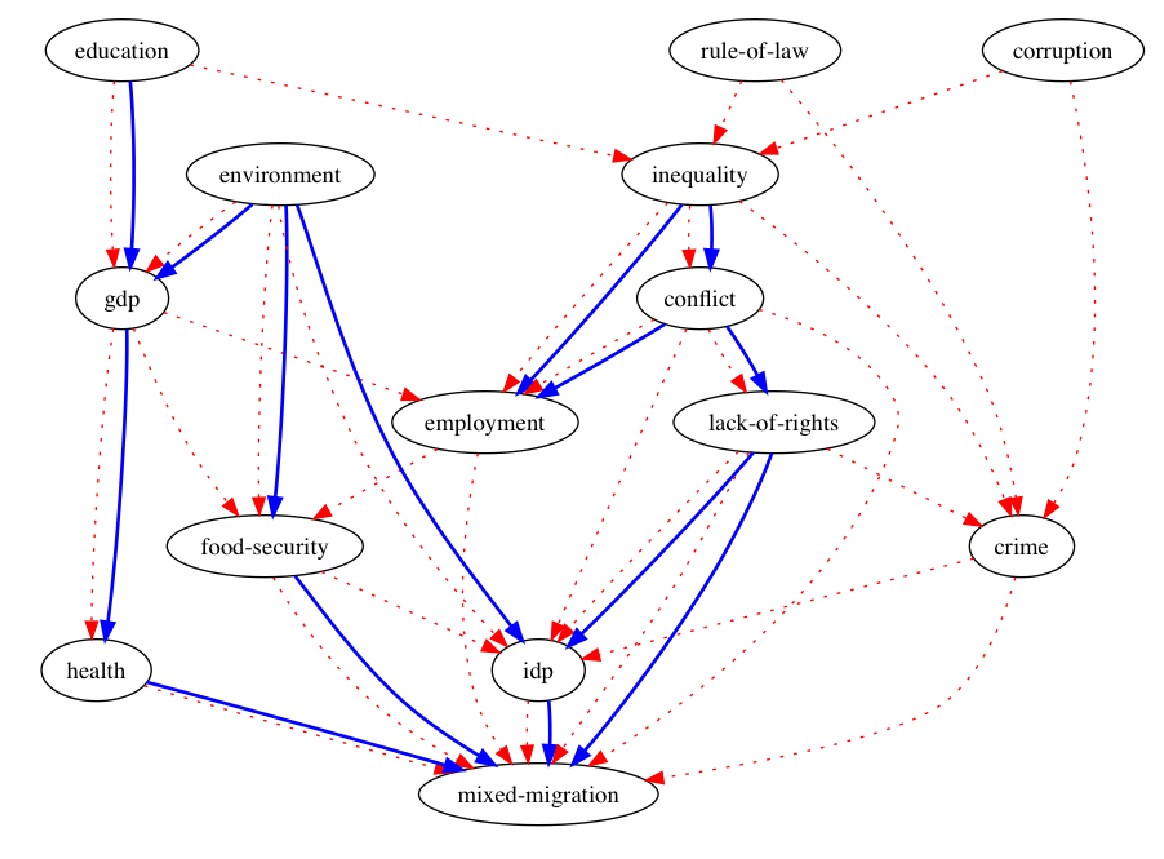

In [57]:
with tempfile.NamedTemporaryFile() as tf:
    G.draw(tf.name, format='png', prog='dot')
    img = mpl_image.imread(tf.name)
    plt.imshow(img)
    plt.axis('off')

In [59]:
[(clus[parent.name], clus[child.name]) for parent, child in model.edges]

[('inequality', 'conflict'),
 ('inequality', 'conflict'),
 ('environment', 'food-security'),
 ('environment', 'food-security'),
 ('environment', 'food-security'),
 ('environment', 'food-security'),
 ('idp', 'mixed-migration'),
 ('lack-of-rights', 'mixed-migration'),
 ('food-security', 'mixed-migration'),
 ('health', 'mixed-migration'),
 ('idp', 'mixed-migration'),
 ('lack-of-rights', 'mixed-migration'),
 ('food-security', 'mixed-migration'),
 ('health', 'mixed-migration'),
 ('idp', 'mixed-migration'),
 ('lack-of-rights', 'mixed-migration'),
 ('food-security', 'mixed-migration'),
 ('health', 'mixed-migration'),
 ('idp', 'mixed-migration'),
 ('lack-of-rights', 'mixed-migration'),
 ('food-security', 'mixed-migration'),
 ('health', 'mixed-migration'),
 ('idp', 'mixed-migration'),
 ('lack-of-rights', 'mixed-migration'),
 ('food-security', 'mixed-migration'),
 ('health', 'mixed-migration'),
 ('idp', 'mixed-migration'),
 ('lack-of-rights', 'mixed-migration'),
 ('food-security', 'mixed-migrati